In [ ]:
!pip install spacy
!pip install git+https://github.com/plandes/self-attentive-parser -qqq
!pip install nltk
!pip uninstall protobuf
!pip install protobuf==3.20.3
!pip install benepar
!pip install svgling
!pip install networkx
!python -m spacy download en

In [2]:
import re
import nltk
import benepar
import spacy
import networkx as nx
import torch

nltk.download('punkt')
benepar.download('benepar_en3')
parser = benepar.Parser("benepar_en3")
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package benepar_en3 to /root/nltk_data...
[nltk_data]   Package benepar_en3 is already up-to-date!


### option 1.하나씩 그래프를 만들 경우
- Constituency parsing graph 
- 노드 : 문법 노드 + 단어노드
- 엣지 : 노드 연결여부

In [3]:
# 문법적 구조 노드 종류
tag_list = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', 'S', 'SBAR', 'SBARQ', 'SINV', 'SQ', 'ADJP', 'ADVP', 'CONJP', 'FRAG', 'INTJ', 'LST', 'NAC', 'NP', 'NX', 'PP', 'PRN', 'PRT', 'QP', 'RRC', 'UCP', 'VP', 'WHADJP', 'WHADVP', 'WHNP', 'WHPP', 'X', '.', ',', '?']

In [4]:
def create_cs_graph(text):
    graph = nx.Graph()
    tree = parser.parse(text)

    node_texts = [] # 노드           -> 자연어
    edge_texts = [] # (노드, 노드)쌍  -> 자연어
    edge_index = [] # edge index     ->  index
    node_index = 0
    first_ancestor_info = [] # (단어노드, 단어노드의 조상노드)쌍 -> 자연어
    labels = []

    
    ########## Tree 구조 탐색 ###############
    def traverse_tree(tree, ancestors=[]):
        nonlocal node_index
        src = re.sub(r'\.\d+(\.\d+)*', '', tree.label())
        src_index = node_index
        node_index += 1

        if src not in graph:
            graph.add_node(src)
            node_texts.append(src)

        for i, child in enumerate(tree):
            if type(child) is nltk.Tree: # 구문노드
                tgt = re.sub(r'\.\d+(\.\d+)*', '', child.label())
                tgt_index = node_index
                node_index += 1

                graph.add_node(tgt)
                node_texts.append(tgt)

                graph.add_edge(src, tgt)
                edge_texts.append((src, tgt))
                # edge_index.append([src_index, tgt_index])

                # 현재 노드를 조상 목록에 추가하고 하위 트리를 탐색
                traverse_tree(child, ancestors + [src])
                
            else: # 단어노드
                leaf = re.sub(r'\.\d+(\.\d+)*', '', child)
                leaf_index = node_index
                node_index += 1
                
                graph.add_node(leaf)
                node_texts.append(leaf)

                graph.add_edge(src, leaf)
                edge_texts.append((src, leaf))
                # edge_index.append([src_index, leaf_index])

                # 첫 번째 조상 노드를 찾아 저장
                if ancestors and leaf not in tag_list:
                    first_ancestor_info.append((leaf, ancestors[-1]))  
                    
    traverse_tree(tree)
    
    ##################### edgeg index ##############################
    
    def edge_index_search(tree, parent_index=-1, counter=[0]):
        current_index = counter[0]
        labels.append(tree.label() if type(tree) == nltk.tree.Tree else tree)
        counter[0] += 1
        if type(tree) == nltk.tree.Tree:
            for subtree in tree:
                edge_index.append([current_index, counter[0]])
                edge_index.append([counter[0], current_index])
                edge_index_search(subtree, counter[0], counter)
            # total_edge_index.append(edge_index)
    
    edge_index_search(tree)

    graph_data = {
        'edge_index': torch.tensor(edge_index).T,
        'node_tokens' : node_texts,
        'edge_tokens' : edge_texts,
        'first_ancestor_info': first_ancestor_info,
    }
    
    return graph_data

In [7]:
graph_data = create_cs_graph('a womna cutting a large white cloth.')
graph_data

{'edge_index': tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  2,  5,  5,  6,  1,  7,  7,  8,  8,  9,
           7, 10, 10, 11, 11, 12, 10, 13, 13, 14, 10, 15, 15, 16, 10, 17, 17, 18,
           1, 19, 19, 20],
         [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  2,  6,  5,  7,  1,  8,  7,  9,  8,
          10,  7, 11, 10, 12, 11, 13, 10, 14, 13, 15, 10, 16, 15, 17, 10, 18, 17,
          19,  1, 20, 19]]),
 'node_tokens': ['TOP',
  'NP',
  'NP',
  'DT',
  'a',
  'NN',
  'womna',
  'VP',
  'VBG',
  'cutting',
  'NP',
  'DT',
  'a',
  'JJ',
  'large',
  'JJ',
  'white',
  'NN',
  'cloth',
  '.',
  '.'],
 'edge_tokens': [('TOP', 'NP'),
  ('NP', 'NP'),
  ('NP', 'DT'),
  ('DT', 'a'),
  ('NP', 'NN'),
  ('NN', 'womna'),
  ('NP', 'VP'),
  ('VP', 'VBG'),
  ('VBG', 'cutting'),
  ('VP', 'NP'),
  ('NP', 'DT'),
  ('DT', 'a'),
  ('NP', 'JJ'),
  ('JJ', 'large'),
  ('NP', 'JJ'),
  ('JJ', 'white'),
  ('NP', 'NN'),
  ('NN', 'cloth'),
  ('NP', '.'),
  ('.', '.')],
 'first_ancestor_info': [('a', 'NP'),
  ('womna', 'N

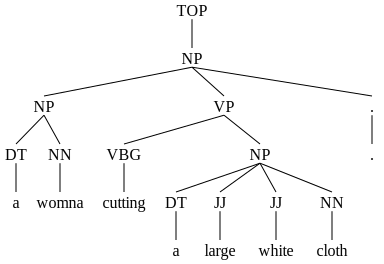

In [6]:
# 생성된 Constituency parsing graph 예시
tree = parser.parse('a womna cutting a large white cloth.') # Input caption
tree

### option2. 데이터셋 한번에 생성하기 (1개 caption = 1개 그래프) : 데이터 경로및 환경 코드 수정 필요

In [ ]:
import os
import os.path as op

import json
import pickle
import random
from typing import List

from utils.iotools import read_json
from utils.utils import pre_caption
from utils.options import get_args

import spacy
import numpy as np
import networkx as nx

from PIL import Image
# import clip

import torch
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_url

from .bases import BaseDataset
from utils.simple_tokenizer import SimpleTokenizer
from datasets.bases import tokenize

import re

import google.protobuf
import nltk
import benepar
from nltk import Tree
import networkx as nx


nltk.download('punkt')
benepar.download('benepar_en3')
parser = benepar.Parser("benepar_en3")
# nlp = spacy.load('en_core_web_sm')

tag_list = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', 'S', 'SBAR', 'SBARQ', 'SINV', 'SQ', 'ADJP', 'ADVP', 'CONJP', 'FRAG', 'INTJ', 'LST', 'NAC', 'NP', 'NX', 'PP', 'PRN', 'PRT', 'QP', 'RRC', 'UCP', 'VP', 'WHADJP', 'WHADVP', 'WHNP', 'WHPP', 'X', '.', ',', '?']

# data preprocessing
def pre_caption(caption, max_words=50):
    caption = re.sub(
        r"([.!\"()*#:;~])",       
        ' ',
        caption.lower(),
    )
    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n') 
    caption = caption.strip(' ')

    caption = re.sub(
        r"\"(.+?)\"",
        r"\1",
        caption,
    )


    caption_words = caption.split(' ')
    if len(caption_words) > max_words:
        caption = ' '.join(caption_words[:max_words])

    return caption

device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)

class COCO_CS(Dataset):
    
    dataset_dir = 'COCO'
    
    def __init__(self, root=''):
        super(COCO_CS, self).__init__()
        
        args = get_args()
        self.dataset_dir = op.join(root, self.dataset_dir)
        self.tokenizer = SimpleTokenizer()

        self.coco_train_path = '/mount/MGM_train/data/COCO/coco_karpathy/train_caption_id.pk'
        self.coco_val_path = '/mount/MGM_train/data/COCO/coco_karpathy/val_caption_id.json'

        self.train, self.train_id_container = self._process_data(self.coco_train_path, training=True)
        self.val, self.val_id_container = self._process_data(self.coco_val_path)

        
        self.train_graphs = self.generate_constituency_graph(self.train,training="train")
        self.val_graphs = self.generate_constituency_graph(self.val,training="val")
        

    def _process_data(self, anno_path: str, training=False):
        if training:
            self.annotation = pickle.load(open(anno_path, 'rb'))
            
            self.img_ids = {}
            n = 0
            pid_container = set()
            processed_data = []
            
            for ann in self.annotation:

                image_id = ann['image'].split('/')[-1].strip('.jpg').split('_')[-1]
                img_id = int(image_id)
                
                if img_id not in self.img_ids.keys():
                    
                    self.img_ids[img_id] = n

                    pid_container.add(self.img_ids[img_id])
                    n += 1

                caption = pre_caption(ann['caption']) 
                instance_id = ann['instance_id']
  
                data = {
                    'caption' : caption,
                    'img_id' : image_id,
                    'instance_id' : instance_id
                }
                processed_data.append((data))
            for idx, pid in enumerate(pid_container):
                    # check pid begin from 0 and no break
                    assert idx == pid, f"idx: {idx} and pid: {pid} are not match"
            return processed_data, pid_container
        
        else:
            self.annotation = json.load(open(os.path.join(anno_path), 'r'))
        
            self.img_ids = {}
            n = 0
            pid_container = set()
            processed_data = []
            
            for ann in self.annotation:
                image_id = ann['image'].split('/')[-1].strip('.jpg').split('_')[-1]
                img_id = int(image_id)
                if img_id not in self.img_ids.keys():
                    self.img_ids[img_id] = n
                    pid_container.add(self.img_ids[img_id])
                    n += 1
                
                caption = pre_caption(ann['caption'])
                instance_id = ann['id']

                data = {
                    'caption' : caption,
                    'img_id' : image_id,
                    'instance_id' : instance_id
                }
                processed_data.append((data))
            for idx, pid in enumerate(pid_container):
                    # check pid begin from 0 and no break
                    assert idx == pid, f"idx: {idx} and pid: {pid} are not match"
            # print(len(pid_container))

            return processed_data, pid_container
        
    def generate_constituency_graph(self, data, training=False):

        if training == "train":
            for i, caption in enumerate(data):
 
                # Constituency Parsing Text Graph 생성
                graph = nx.Graph()

                node_texts = []
                edge_texts = []
                edge_index = []
                node_index = 0
                first_ancestor_info = []
                labels = []

                tree = parser.parse(f"{caption['caption']}")

                def traverse_tree(tree, ancestors=[]):
                    nonlocal node_index
                    src = re.sub(r'\.\d+(\.\d+)*', '', tree.label())
                    src_index = node_index
                    node_index += 1

                    if src not in graph:
                        graph.add_node(src)
                        node_texts.append(src)

                    for i, child in enumerate(tree):
                        if type(child) is nltk.Tree:
                            tgt = re.sub(r'\.\d+(\.\d+)*', '', child.label())
                            tgt_index = node_index
                            node_index += 1

                            graph.add_node(tgt)
                            node_texts.append(tgt)

                            graph.add_edge(src, tgt)
                            edge_texts.append((src, tgt))
                            # edge_index.append([src_index, tgt_index])

                            # 현재 노드를 조상 목록에 추가하고 하위 트리를 탐색
                            traverse_tree(child, ancestors + [src])
                        else:
                            leaf = re.sub(r'\.\d+(\.\d+)*', '', child)
                            leaf_index = node_index
                            node_index += 1
                            
                            graph.add_node(leaf)
                            node_texts.append(leaf)

                            graph.add_edge(src, leaf)
                            edge_texts.append((src, leaf))
                            # edge_index.append([src_index, leaf_index])
                            
                            # 첫 번째 조상 노드를 찾아 저장
                            if ancestors and leaf not in tag_list:
                                first_ancestor_info.append((leaf, ancestors[-1]))  # <-- 수정된 부분

                traverse_tree(tree)
                
                ##################### edgeg index ##############################
    
                def edge_index_search(tree, parent_index=-1, counter=[0]):
                    current_index = counter[0]
                    labels.append(tree.label() if type(tree) == nltk.tree.Tree else tree)
                    counter[0] += 1
                    if type(tree) == nltk.tree.Tree:
                        for subtree in tree:
                            edge_index.append([current_index, counter[0]])
                            edge_index.append([counter[0], current_index])
                            edge_index_search(subtree, counter[0], counter)
                
                edge_index_search(tree)

                graph_data = {
                    'edge_index': torch.tensor(edge_index).T,
                    'node_tokens' : node_texts,
                    'edge_tokens' : edge_texts,
                    'first_ancestor_info': first_ancestor_info,
                }
                
                
                graph_file_path = f'/data/data2/IRRA/COCO/cs_graph_train_v3/train_graph_{i}.pt'
                torch.save(graph_data, graph_file_path)
                print(f"Creating Train Graph {i+1}/{len(data)}")

            return graph_data
        
        elif training == "val":
            for i, caption in enumerate(data):
 
                # Constituency Parsing Text Graph 생성
                graph = nx.Graph()

                node_texts = []
                edge_texts = []
                edge_index = []
                node_index = 0
                first_ancestor_info = []
                labels = []

                tree = parser.parse(f"{caption['caption']}")
                
                def traverse_tree(tree, ancestors=[]):
                    nonlocal node_index
                    src = re.sub(r'\.\d+(\.\d+)*', '', tree.label())
                    src_index = node_index
                    node_index += 1

                    if src not in graph:
                        graph.add_node(src)
                        node_texts.append(src)

                    for i, child in enumerate(tree):
                        if type(child) is nltk.Tree:
                            tgt = re.sub(r'\.\d+(\.\d+)*', '', child.label())
                            tgt_index = node_index
                            node_index += 1

                            graph.add_node(tgt)
                            node_texts.append(tgt)

                            graph.add_edge(src, tgt)
                            edge_texts.append((src, tgt))
                            # edge_index.append([src_index, tgt_index])

                            # 현재 노드를 조상 목록에 추가하고 하위 트리를 탐색
                            traverse_tree(child, ancestors + [src])
                        else:
                            leaf = re.sub(r'\.\d+(\.\d+)*', '', child)
                            leaf_index = node_index
                            node_index += 1
                            
                            graph.add_node(leaf)
                            node_texts.append(leaf)

                            graph.add_edge(src, leaf)
                            edge_texts.append((src, leaf))
                            # edge_index.append([src_index, leaf_index])
                            
                            # 첫 번째 조상 노드를 찾아 저장
                            if ancestors and leaf not in tag_list:
                                first_ancestor_info.append((leaf, ancestors[-1]))  # <-- 수정된 부분

                traverse_tree(tree)
                
                ##################### edgeg index ##############################
    
                def edge_index_search(tree, parent_index=-1, counter=[0]):
                    current_index = counter[0]
                    labels.append(tree.label() if type(tree) == nltk.tree.Tree else tree)
                    counter[0] += 1
                    if type(tree) == nltk.tree.Tree:
                        for subtree in tree:
                            edge_index.append([current_index, counter[0]])
                            edge_index.append([counter[0], current_index])
                            edge_index_search(subtree, counter[0], counter)
                
                edge_index_search(tree)

                graph_data = {
                    'edge_index': torch.tensor(edge_index).T,
                    'node_tokens' : node_texts,
                    'edge_tokens' : edge_texts,
                    'first_ancestor_info': first_ancestor_info,
                }

                graph_file_path = f'/data/data2/IRRA/COCO/cs_graph_val_v3/val_graph_{i}.pt'
                torch.save(graph_data, graph_file_path)
                print(f"Creating VAL Graph {i+1}/{len(data)}")
            
                
            return graph_data

        else:
            pass
            

### Dependency Parsing Graph

In [ ]:
import os
import os.path as op

import json
import pickle
import random
from typing import List

from utils.iotools import read_json
from utils.utils import pre_caption
from utils.options import get_args

import spacy
import numpy as np
import networkx as nx

from PIL import Image


import torch
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_url

from .bases import BaseDataset
from utils.simple_tokenizer import SimpleTokenizer
from datasets.bases import tokenize



nlp = spacy.load("en_core_web_sm")
device = "cuda" if torch.cuda.is_available() else "cpu"

class COCO(Dataset):
    
    dataset_dir = 'COCO'
    
    def __init__(self, root='', prompt=''):
        super(COCO, self).__init__()
        
        args = get_args()
        self.dataset_dir = op.join(root, self.dataset_dir)
        self.tokenizer = SimpleTokenizer()
           
        self.prompt = prompt
        
        self.train_filenames = '/mount/MGM_train/data/COCO/coco_karpathy/train_caption_id.pk'
        self.val_filenames = '/mount/MGM_train/data/COCO/coco_karpathy/val_caption_id.json'
        
        
        # self.train, self.train_id_container = self._process_data(self.train_filenames, training=True)
        self.val, self.val_id_container = self._process_data(self.val_filenames)
        
        
        self.train_graphs = self.generate_dependency_graph(self.train, training="train")
        # self.val_graphs = self.generate_dependency_graph(self.val, training="val")
        exit()


    def _process_data(self, anno_path: str, training=False):
        if training:
            self.annotation = pickle.load(open(anno_path, 'rb'))
            
            self.img_ids = {}
            n = 0
            pid_container = set()
            processed_data = []
            
            for ann in self.annotation:
                # img_id = ann['image_id']
                # pid_container.add(img_id)
                image_id = ann['image'].split('/')[-1].strip('.jpg').split('_')[-1]
                img_id = int(image_id)
                
                if img_id not in self.img_ids.keys():
                    
                    self.img_ids[img_id] = n
                    pid_container.add(self.img_ids[img_id])
                    n += 1

                
                caption = self.prompt + pre_caption(ann['caption']) 
                instance_id = ann['instance_id']

                data = {
                    'caption' : caption,
                    'img_id' : image_id,
                    'instance_id' : instance_id
                }
                processed_data.append((data))
            for idx, pid in enumerate(pid_container):
                    assert idx == pid, f"idx: {idx} and pid: {pid} are not match"
            return processed_data, pid_container
        
        else:
            self.annotation = json.load(open(os.path.join(anno_path), 'r'))
        
            self.img_ids = {}
            n = 0
            pid_container = set()
            processed_data = []
            
            for ann in self.annotation:
                image_id = ann['image'].split('/')[-1].strip('.jpg').split('_')[-1]
                img_id = int(image_id)
                if img_id not in self.img_ids.keys():
                    self.img_ids[img_id] = n
                    pid_container.add(self.img_ids[img_id])
                    n += 1
                
                caption = self.prompt + pre_caption(ann['caption']) 
                instance_id = ann['id']
                
                data = {
                    'caption' : caption,
                    'img_id' : image_id,
                    'instance_id' : instance_id
                }
                processed_data.append((data))
            for idx, pid in enumerate(pid_container):
                    assert idx == pid, f"idx: {idx} and pid: {pid} are not match"
            print(len(pid_container))
            
            return processed_data, pid_container
        
    def generate_dependency_graph(self, data, training=False):
        if training == "train":
            for i, caption in enumerate(data):
                doc = nlp(caption['caption'])
                instance_id = caption['instance_id']
                # Dependecny Parsing Text Graph 생성
                G = nx.DiGraph()

                edge_index = []
                node_texts = []
                edge_texts = []
                triplets = []

                for j, token in enumerate(doc):
                    # print(len(doc))
                    G.add_node(token.i, label=token.text)
                    
                    node_text = token.text
                    node_texts.append(node_text)

                for token in doc:
                    # 두 노드 간 dependency가 있는 경우 엣지 연결
                    if token.dep_ != 'ROOT':
                        G.add_edge(token.head.i, token.i, label=token.dep_)
                        G.add_edge(token.i, token.head.i, label=token.dep_)

                        #엣지 CLIP 임베딩 생성
                        triplet = f"{token.head.text} - {token.dep_} - {token.text}"
                        edge_texts.append(token.dep_)
                        triplets.append(triplet)
                        
                        # edge index 추가
                        edge_index.append([token.head.i, token.i])
                        edge_index.append([token.i, token.head.i])
                                
                graph_data = {
                    'edge_index': torch.tensor(edge_index).T,
                    'node_tokens' : node_texts,
                    'edge_tokens' : edge_texts,
                    'triplets' : triplets,
                }

                # graph_file_path = f'/mount/coco_irra/data/coco/train/train_graph_{instance_id}.pt'
                graph_file_path = f'/data/data2/IRRA/COCO/tmp/dp_train/train_graph_{instance_id}.pt'
                # torch.save(graph_data, graph_file_path)

                print(f"Creating Train Graph {j+1}/{len(doc)} of dataset {i+1}/{len(data)}")
            return graph_data
        
        elif training == "val":

            for i, caption in enumerate(data):
                doc = nlp(caption['caption'])
                instance_id = caption['instance_id']

                # Dependecny Parsing Text Graph 생성
                G = nx.DiGraph()
                
                edge_index = []
                node_texts = []
                edge_texts = []
                triplets = []

                for j, token in enumerate(doc):
                    # print(len(doc))
                    G.add_node(token.i, label=token.text)
                    
                    node_text = token.text
                    node_texts.append(node_text)

                for token in doc:
                    # 두 노드 간 dependency가 있는 경우 엣지 연결
                    if token.dep_ != 'ROOT':
                        G.add_edge(token.head.i, token.i, label=token.dep_)
                        G.add_edge(token.i, token.head.i, label=token.dep_)

                        triplet = f"{token.head.text} - {token.dep_} - {token.text}"
                        edge_texts.append(token.dep_)
                        triplets.append(triplet)

                        # edge index 추가
                        edge_index.append([token.head.i, token.i])
                        edge_index.append([token.i, token.head.i])
             
                graph_data = {
                    'edge_index': torch.tensor(edge_index).T,
                    'node_tokens' : node_texts,
                    'edge_tokens' : edge_texts,
                    'triplets' : triplets,
                }
                
                # graph_file_path = f'/mount/MGM_train/data/COCO/val/val_graph_{instance_id}.pt'
                graph_file_path = f'/data/data2/IRRA/COCO/tmp/dp_val/val_graph_{instance_id}.pt'
                # torch.save(graph_data, graph_file_path)
                print(f"Creating Validation Graph {j+1}/{len(doc)} of dataset {i+1}/{len(data)}")
            return graph_data

        else:
           pass